In [85]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pylab as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from scipy.stats import mstats
from tqdm import tqdm

from sklearn import metrics, cross_validation, feature_selection, ensemble, gaussian_process, linear_model, naive_bayes, neighbors, svm, tree, discriminant_analysis, model_selection
from xgboost import XGBClassifier
from imblearn import under_sampling, over_sampling

import pydotplus
from IPython.display import Image
from io import StringIO

import warnings
warnings.filterwarnings('ignore')

In [86]:
def generate_cmap(colors):
    
    values = range(len(colors))
    vmax = np.ceil(np.max(values))
    color_list = []
    for v, c in zip(values, colors):
        color_list.append((v/vmax, c))
    return matplotlib.colors.LinearSegmentedColormap.from_list('custom_cmap', color_list)

base_color = 'darkturquoise'
base_color2 = 'gray'
cm = generate_cmap([base_color2, 'white', base_color])

In [87]:
df = pd.read_csv('./data/creditcard.csv')

In [88]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [89]:
print(df.dtypes)
print('-'*50)
print(df.isnull().sum())

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object
--------------------------------------------------
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype

In [90]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [91]:
df['Class'].sum(), df['Class'].count(), df['Class'].sum() / df['Class'].count()

(492, 284807, 0.001727485630620034)

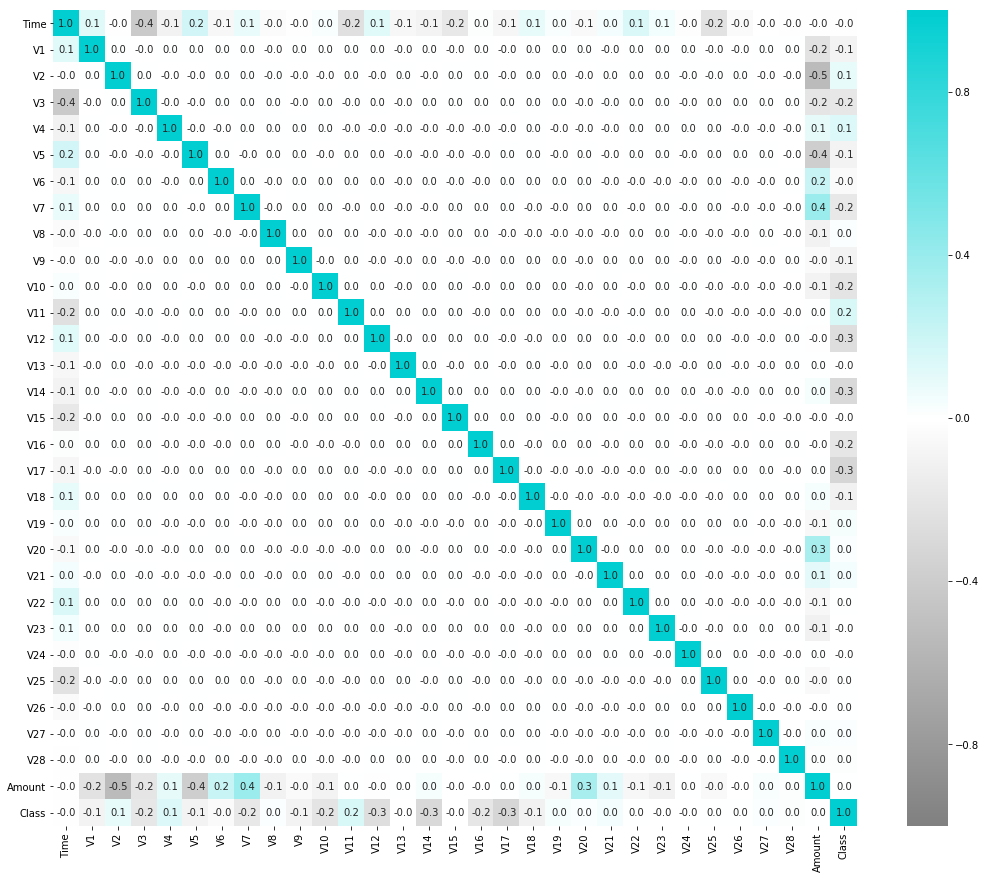

In [116]:
plt.figure(figsize=(18,15))
sns.heatmap(df.corr(), annot=True, vmax=1, vmin=-1, fmt='.1f', cmap=cm)
plt.show()

In [117]:
cols = df.columns.tolist()
cols.remove('Class')

positive_cnt = int(df['Class'].sum())
rus = under_sampling.RandomUnderSampler(sampling_strategy={0:positive_cnt, 1:positive_cnt}, random_state=0)
data_x_sample, data_y_sample  = rus.fit_sample(df[cols], df[['Class']])

len(data_x_sample), len(data_y_sample), df['Class'].sum()

(984, 984, 492)

100%|██████████| 6/6 [00:17<00:00,  2.94s/it]


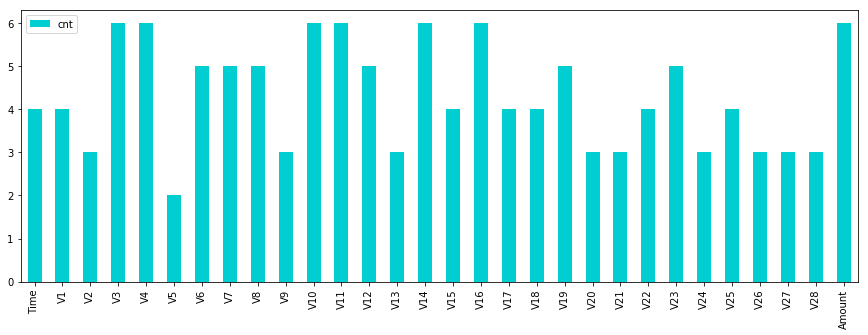

In [118]:
# 特徴量を選択する

feature_importance_models = [
    ensemble.AdaBoostClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),
    tree.DecisionTreeClassifier(),
    XGBClassifier()
]

scoring = ['accuracy']
df_rfe_cols_cnt = pd.DataFrame(columns=['cnt'], index=cols)
df_rfe_cols_cnt['cnt'] = 0

for i, model in tqdm(enumerate(feature_importance_models), total=len(feature_importance_models)):
    
    rfe = feature_selection.RFECV(model, step=3)
    rfe.fit(data_x_sample, data_y_sample)
    rfe_cols = df[cols].columns.values[rfe.get_support()]
    df_rfe_cols_cnt.loc[rfe_cols, 'cnt'] += 1
    
df_rfe_cols_cnt.plot(kind='bar', color=base_color, figsize=(15, 5))
plt.show()

In [119]:
x_cols = df_rfe_cols_cnt[df_rfe_cols_cnt['cnt'] >= 4].index
x_cols

Index(['Time', 'V1', 'V3', 'V4', 'V6', 'V7', 'V8', 'V10', 'V11', 'V12', 'V14',
       'V15', 'V16', 'V17', 'V18', 'V19', 'V22', 'V23', 'V25', 'Amount'],
      dtype='object')

In [120]:
positive_cnt = int(df['Class'].sum())
rus = under_sampling.RandomUnderSampler(sampling_strategy={0:positive_cnt, 1:positive_cnt}, random_state=0)
data_x_sample, data_y_sample = rus.fit_sample(df[x_cols], df[['Class']])

len(data_x_sample), len(data_y_sample), df['Class'].sum()

(984, 984, 492)

100%|██████████| 16/16 [00:15<00:00,  1.03it/s]


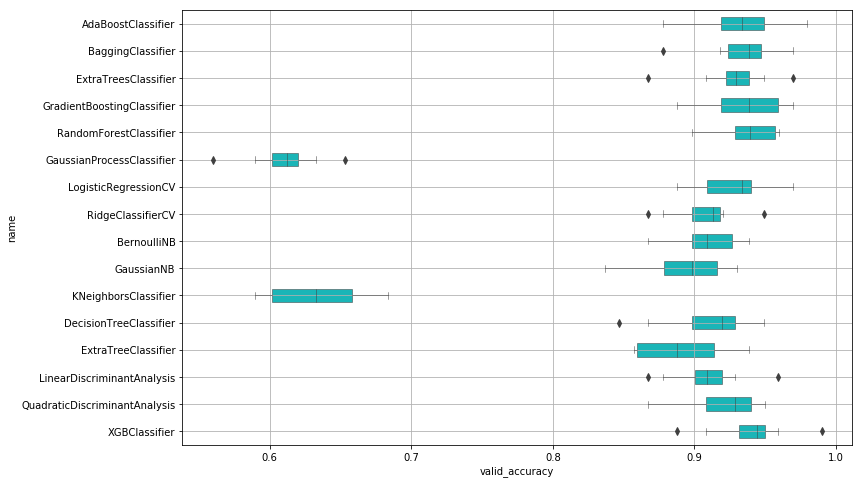

In [121]:
# 特徴量を選択して、複数のモデルで精度を調査する

models = [

    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),

    #Gaussian Processes
    gaussian_process.GaussianProcessClassifier(),
    
    #GLM
    linear_model.LogisticRegressionCV(),
    linear_model.RidgeClassifierCV(),
    
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    #Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),

    #xgboost
    XGBClassifier()
    
]

df_compare = pd.DataFrame(columns=['name', 'train_accuracy', 'valid_accuracy', 'time'])
scoring = ['accuracy']

for model in tqdm(models):
    
    name = model.__class__.__name__
    
    cv_rlts = model_selection.cross_validate(model, data_x_sample, data_y_sample, scoring=scoring, cv=10, return_train_score=True)

    for i in range(10):
        s = pd.Series([name, cv_rlts['train_accuracy'][i], cv_rlts['test_accuracy'][i], cv_rlts['fit_time'][i]], index=df_compare.columns, name=name+str(i))
        df_compare = df_compare.append(s)
        
plt.figure(figsize=(12,8))
sns.boxplot(data=df_compare, y='name', x='valid_accuracy', orient='h', color=base_color, linewidth=0.5, width=0.5)
plt.grid()
plt.show()

In [122]:
df_compare.groupby('name').mean().sort_values(by='valid_accuracy', ascending=False)

,train_accuracy,valid_accuracy,time
name,,,
XGBClassifier,0.996837,0.940020,0.122205
RandomForestClassifier,0.993564,0.936939,0.021243
GradientBoostingClassifier,0.998758,0.934939,0.223336
BaggingClassifier,0.992887,0.934898,0.089075
AdaBoostClassifier,0.991758,0.930878,0.283883
LogisticRegressionCV,0.936538,0.927857,0.179359
ExtraTreesClassifier,1.000000,0.927857,0.022452
QuadraticDiscriminantAnalysis,0.928070,0.918592,0.001882
LinearDiscriminantAnalysis,0.912037,0.909531,0.003465


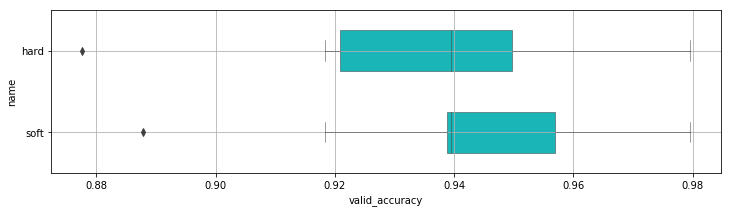

In [125]:
# 精度の良いモデルを選んで、投票モデルを学習

vote_models = [

    #Ensemble Methods
    ('abc', ensemble.AdaBoostClassifier()),
    ('bc', ensemble.BaggingClassifier()),
    ('etsc', ensemble.ExtraTreesClassifier()),
    ('gbc', ensemble.GradientBoostingClassifier()),
    ('rfc', ensemble.RandomForestClassifier()),

    #Gaussian Processes
    #('gpc', gaussian_process.GaussianProcessClassifier()),
    
    #GLM
    ('lrcv', linear_model.LogisticRegressionCV()),
    #('rccv', linear_model.RidgeClassifierCV()), # unable soft voting
    
    #Navies Bayes
    #('bnb', naive_bayes.BernoulliNB()),
    #('gnb', naive_bayes.GaussianNB()),
    
    #Nearest Neighbor
    #('knc', neighbors.KNeighborsClassifier()),
    
    #Trees    
    #('dtc', tree.DecisionTreeClassifier()),
    #('etc', tree.ExtraTreeClassifier()),
    
    #Discriminant Analysis
    #('lda', discriminant_analysis.LinearDiscriminantAnalysis()),
    #('qda', discriminant_analysis.QuadraticDiscriminantAnalysis()),

    #xgboost
    ('xgbc', XGBClassifier())
    
]

df_compare = pd.DataFrame(columns=['name', 'train_accuracy', 'valid_accuracy', 'time'])
scoring = ['accuracy']

vote_hard_model = ensemble.VotingClassifier(estimators=vote_models, voting='hard')
cv_rlts = model_selection.cross_validate(vote_hard_model, data_x_sample, data_y_sample, cv=10, scoring=scoring)
for i in range(10):
    s = pd.Series(['hard', cv_rlts['train_accuracy'][i], cv_rlts['test_accuracy'][i], cv_rlts['fit_time'][i]], index=df_compare.columns, name='hard'+str(i))
    df_compare = df_compare.append(s)
    
vote_soft_model = ensemble.VotingClassifier(estimators=vote_models , voting='soft')
cv_rlts = model_selection.cross_validate(vote_soft_model, data_x_sample, data_y_sample, cv=10, scoring=scoring)
for i in range(10):
    s = pd.Series(['soft', cv_rlts['train_accuracy'][i], cv_rlts['test_accuracy'][i], cv_rlts['fit_time'][i]], index=df_compare.columns, name='soft'+str(i))
    df_compare = df_compare.append(s)
    
plt.figure(figsize=(12,3))
sns.boxplot(data=df_compare, y='name', x='valid_accuracy', orient='h', color=base_color, linewidth=0.5, width=0.5)
plt.grid()
plt.show()

In [126]:
df_compare.groupby('name').mean().sort_values(by='valid_accuracy', ascending=False)

,train_accuracy,valid_accuracy,time
name,,,
soft,0.999549,0.942061,0.810816
hard,0.998193,0.935939,0.853016


In [127]:
# 各モデルのハイパーパラメータをグリッドサーチ

grid_n_estimator = [10, 50, 100, 300]
grid_ratio = [.1, .25, .5, .75, 1.0]
grid_learn = [.01, .03, .05, .1, .25]
grid_max_depth = [2, 4, 6, 8, 10, None]
grid_min_samples = [5, 10, .03, .05, .10]
grid_criterion = ['gini', 'entropy']
grid_bool = [True, False]
grid_seed = [0]

grid_param = [
    
    #AdaBoostClassifier
    [{ 
        'n_estimators': grid_n_estimator, #default=50
        'learning_rate': grid_learn, #default=1
        #'algorithm': ['SAMME', 'SAMME.R'], #default=’SAMME.R
        'random_state': grid_seed
    }],
    
    #BaggingClassifier
    [{
        'n_estimators': grid_n_estimator, #default=10
        'max_samples': grid_ratio, #default=1.0
        'random_state': grid_seed
     }],

    #ExtraTreesClassifier
    [{
        'n_estimators': grid_n_estimator, #default=10
        'criterion': grid_criterion, #default=”gini”
        'max_depth': grid_max_depth, #default=None
        'random_state': grid_seed
     }],

    #GradientBoostingClassifier
    [{
        #'loss': ['deviance', 'exponential'], #default=’deviance’
        'learning_rate': [.05], #default=0.1
        'n_estimators': [300], #default=100
        #'criterion': ['friedman_mse', 'mse', 'mae'], #default=”friedman_mse”
        'max_depth': grid_max_depth, #default=3   
        'random_state': grid_seed
     }],

    #RandomForestClassifier
    [{
        'n_estimators': grid_n_estimator, #default=10
        'criterion': grid_criterion, #default=”gini”
        'max_depth': grid_max_depth, #default=None
        'oob_score': [True], #default=False
        'random_state': grid_seed
     }],
    
    #LogisticRegressionCV
    [{
        'fit_intercept': grid_bool, #default: True
        #'penalty': ['l1','l2'],
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], #default: lbfgs
        'random_state': grid_seed
     }],
    
    # ExtraTreeClassifier
    [{}],
    
    # LinearDiscriminantAnalysis
    [{}],
    
    #XGBClassifier
    [{
        'learning_rate': grid_learn, #default: .3
        'max_depth': [1,2,4,6,8,10], #default 2
        'n_estimators': grid_n_estimator, 
        'seed': grid_seed  
     }]
    
]

for model, param in tqdm(zip(vote_models, grid_param), total=len(vote_models)):
    
    best_search = model_selection.GridSearchCV(estimator=model[1], param_grid=param, scoring='roc_auc')
    best_search.fit(data_x_sample, data_y_sample)

    best_param = best_search.best_params_
    model[1].set_params(**best_param)

100%|██████████| 7/7 [02:35<00:00, 22.15s/it]


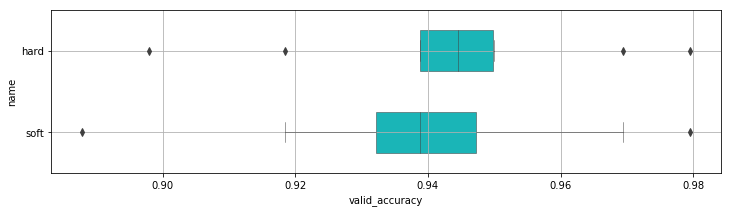

In [134]:
# グリッドサーチしたハイパーパラメータを使ったモデルで、投票モデルを学習

df_compare = pd.DataFrame(columns=['name', 'train_accuracy', 'valid_accuracy', 'time'])
scoring = ['accuracy']

vote_hard_model = ensemble.VotingClassifier(estimators=vote_models, voting='hard')
cv_rlts = model_selection.cross_validate(vote_hard_model, data_x_sample, data_y_sample, cv=10, scoring=scoring)
for i in range(10):
    s = pd.Series(['hard', cv_rlts['train_accuracy'][i], cv_rlts['test_accuracy'][i], cv_rlts['fit_time'][i]], index=df_compare.columns, name='hard'+str(i))
    df_compare = df_compare.append(s)

vote_soft_model = ensemble.VotingClassifier(estimators=vote_models , voting='soft')
cv_rlts = model_selection.cross_validate(vote_soft_model, data_x_sample, data_y_sample, cv=10, scoring=scoring)
for i in range(10):
    s = pd.Series(['soft', cv_rlts['train_accuracy'][i], cv_rlts['test_accuracy'][i], cv_rlts['fit_time'][i]], index=df_compare.columns, name='soft'+str(i))
    df_compare = df_compare.append(s)
    
plt.figure(figsize=(12,3))
sns.boxplot(data=df_compare, y='name', x='valid_accuracy', orient='h', color=base_color, linewidth=0.5, width=0.5)
plt.grid()
plt.show()

In [135]:
df_compare.groupby('name').mean().sort_values(by='valid_accuracy', ascending=False)

,train_accuracy,valid_accuracy,time
name,,,
hard,0.999887,0.943082,9.059538
soft,1.000000,0.939020,7.482919


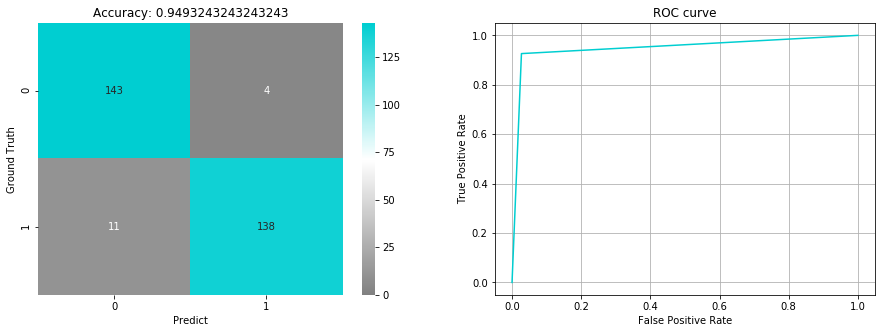

In [136]:
train_x, valid_x, train_y, valid_y = cross_validation.train_test_split(data_x_sample, data_y_sample, test_size=0.3, random_state=0)

vote_soft_model.fit(train_x, train_y)

pred = vote_soft_model.predict(valid_x)

fig, axs = plt.subplots(ncols=2,figsize=(15,5))

sns.heatmap(metrics.confusion_matrix(valid_y, pred), vmin=0, annot=True, fmt='d', cmap=cm, ax=axs[0])
axs[0].set_xlabel('Predict')
axs[0].set_ylabel('Ground Truth')
axs[0].set_title('Accuracy: {}'.format(metrics.accuracy_score(valid_y, pred)))
fpr, tpr, thresholds = metrics.roc_curve(valid_y, pred)
axs[1].plot(fpr, tpr, color=base_color)
axs[1].set_title('ROC curve')
axs[1].set_xlabel('False Positive Rate')
axs[1].set_ylabel('True Positive Rate')
axs[1].grid(True)
plt.show()

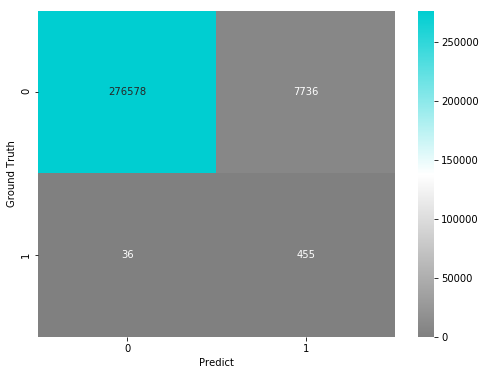

In [137]:
# 上記の結果を、実際の不均衡の比率に合わせた結果の混合行列

confusion_matrix = metrics.confusion_matrix(valid_y, pred)
confusion_matrix_scaled = np.array([
    confusion_matrix[0, :]*(len(df[df['Class'] ==0])/sum(confusion_matrix[0, :])),
    confusion_matrix[1, :]*(len(df[df['Class'] ==1])/sum(confusion_matrix[1, :])),
], dtype=np.int32)

plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix_scaled, vmin=0, annot=True, fmt='d', cmap=cm)
plt.xlabel('Predict')
plt.ylabel('Ground Truth')
plt.show()

それぞれの場合の損益関数を考える

不正利用がないと予測して、実際に不正利用はない時の1アカウント当たりの平均利益を考える $= benefit_{tn}(account)$  
現実問題としては、$benefit_{tn}(account) = 0$ と思われる

不正利用があると予測したが、実際に不正利用はなかった時には、そのアカウントに迷惑をかけることになり、利用停止を解除するコストも発生する $= cost_{fp}(account)$
* https://kurumicat.com/zakki015

不正利用がないと予測したが、実際に不正利用があった時には、不正利用を見逃したことになり、顧客は口座の金額を失う恐れがある  
クレジットカードには盗難保険がついており、不正利用により顧客が失った金額は、クレジットカード会社が負担する $= cost_{fn}(account)$
* https://news.cardmics.com/entry/tonan-hoken-detail/

不正利用があると予測し、実際に不正利用されていた場合には、失うはずであった金額を抑えることが出来たと考える $= benefit_{tp}(account)$

以上のように考えた時のの損益行列は

<table>
    <tr><td>$benefit_{tn}(TN)$</td><td>$cost_{fp}(FP)$</td></tr>
    <tr><td>$cost_{fn}(FN)$</td><td>$benefit_{tp}(TP)$</td></tr>
</table>

と表せる


ここでは仮として、利用停止を解除するコストとして1アカウント当たり平均1万円コストがかかるとする

$cost_{fp}(account) = -1*account$

また、不正利用を検知できず悪用されてしまった場合の1アカウント当たりの平均負担額が100万円かかるとする

$cost_{fn}(account) = -100*account$

不正利用を未然に防ぐことができた金額も100万円と考えられるが、プラスで計算してしまうと二重で計算してしまうことになるため注意が必要  
結果、負担がなかったと考えれば良い

$benefit_{tp}(account) = 0$

In [138]:
def benefit_tn(account):
    return 0*account

def cost_fp(account):
    return -1*account

# 不正利用を検知できずに悪用されてしまったと考える場合

def cost_fn(account):
    return -100*account

def benefit_tp(account):
    return 0*account

# 不正利用を未然に防ぐことができたと考える場合

def cost_fn2(account):
    return 0*account

def benefit_tp2(account):
    return 100*account  

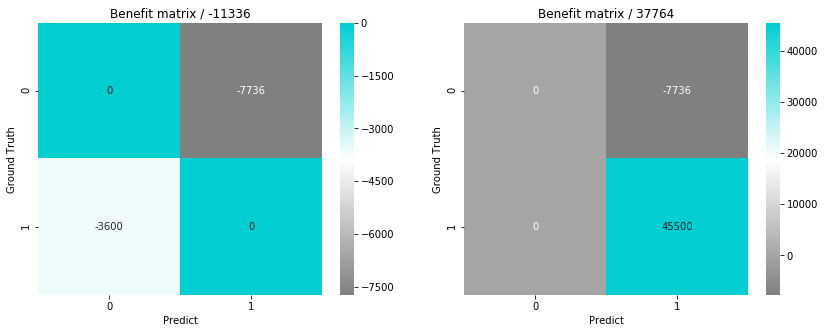

In [139]:
tn, fp, fn, tp = confusion_matrix_scaled.flatten()

fig, axs = plt.subplots(ncols=2, figsize=(14, 5))

bc_matrix = np.array([
    [benefit_tn(tn), cost_fp(fp)],
    [cost_fn(fn), benefit_tp(tp)],
], dtype=np.int)

sns.heatmap(bc_matrix, annot=True, fmt='d', cmap=cm, ax=axs[0])
axs[0].set_xlabel('Predict')
axs[0].set_ylabel('Ground Truth')
axs[0].set_title('Benefit matrix / {}'.format(bc_matrix.sum()))

bc_matrix = np.array([
    [benefit_tn(tn), cost_fp(fp)],
    [cost_fn2(fn), benefit_tp2(tp)],
], dtype=np.int)

sns.heatmap(bc_matrix, annot=True, fmt='d', cmap=cm, ax=axs[1])
axs[1].set_xlabel('Predict')
axs[1].set_ylabel('Ground Truth')
axs[1].set_title('Benefit matrix / {}'.format(bc_matrix.sum()))

plt.show()

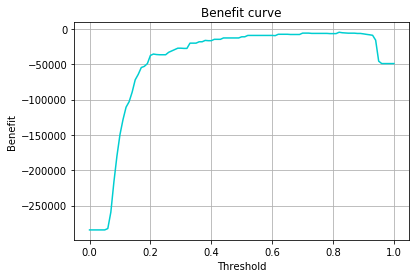

In [140]:
# 利益曲線を作る

pred_prob = vote_soft_model.predict_proba(valid_x)[:, 1] # 不正利用である確率

def get_expected_benefit(confusion_matrix):
    
    confusion_matrix_scaled = np.array([
        confusion_matrix[0, :]*(len(df[df['Class'] ==0])/sum(confusion_matrix[0, :])),
        confusion_matrix[1, :]*(len(df[df['Class'] ==1])/sum(confusion_matrix[1, :])),
    ], dtype=np.int32)
    tn, fp, fn, tp = confusion_matrix_scaled.flatten()
    return benefit_tn(tn)+cost_fp(fp)+cost_fn(fn)+benefit_tp(tp)

thresholds = np.linspace(0, 1, 101)
benefits = np.zeros(len(thresholds))

for i, thresh in enumerate(thresholds):

    pred_tmp = np.zeros((len(valid_y)))
    pred_tmp[np.where(pred_prob > thresh)] = 1
    confusion_matrix = metrics.confusion_matrix(valid_y, pred_tmp)
    benefits[i] = get_expected_benefit(confusion_matrix)
        
plt.plot(thresholds, benefits, color=base_color)
plt.xlabel('Threshold')
plt.ylabel('Benefit')
plt.title('Benefit curve')
plt.grid()
plt.show()

100%|██████████| 20/20 [03:52<00:00, 11.65s/it]


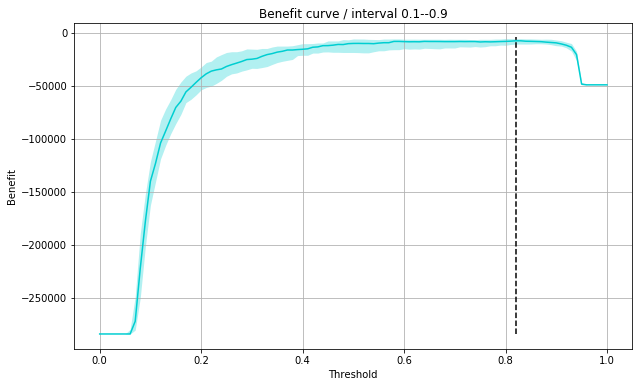

0.8200000000000001

In [141]:
trial_num = 20

thresholds = np.linspace(0, 1, 101)
benefits = np.zeros((trial_num, len(thresholds)))

for trial in tqdm(range(trial_num)):
    
    train_x, valid_x, train_y, valid_y = cross_validation.train_test_split(data_x_sample, data_y_sample, test_size=0.3)
    vote_soft_model.fit(train_x, train_y)
    pred_prob = vote_soft_model.predict_proba(valid_x)[:, 1]

    for i, thresh in enumerate(thresholds):

        pred_tmp = np.zeros((len(valid_y)))
        pred_tmp[np.where(pred_prob > thresh)] = 1
        confusion_matrix = metrics.confusion_matrix(valid_y, pred_tmp)
        benefits[trial, i] = get_expected_benefit(confusion_matrix)
        
plt.figure(figsize=(10,6))
        
lower_benefit, median_benefit, upper_benefit = mstats.mquantiles(benefits, [0.1, 0.5, 0.9], axis=0)

plt.plot(thresholds, median_benefit, color=base_color)
plt.fill_between(thresholds, upper_benefit, lower_benefit, color=base_color, alpha=0.3, linewidth=0)

max_benefit_point = thresholds[median_benefit == median_benefit.max()][0]
plt.vlines([max_benefit_point], benefits.min(), benefits.max(), color='black', linestyles='--') 

plt.xlabel('Threshold')
plt.ylabel('Benefit')
plt.title('Benefit curve / interval 0.1--0.9')
plt.grid()

plt.show()

max_benefit_point

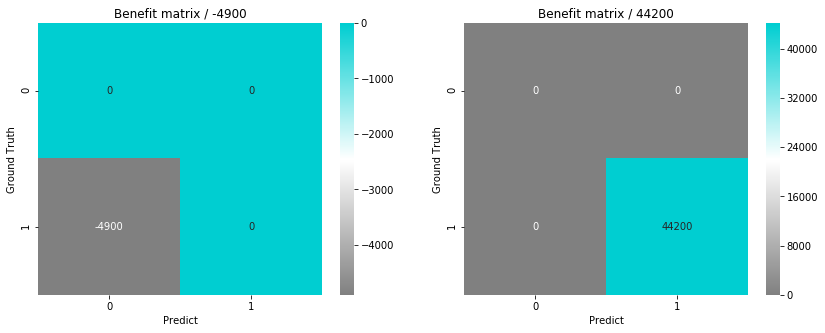

In [142]:
# 利益を最大にする閾値の時の損益行列

prob_thresh = 0.82

train_x, valid_x, train_y, valid_y = cross_validation.train_test_split(data_x_sample, data_y_sample, test_size=0.3, random_state=0)

vote_soft_model.fit(train_x, train_y)

pred_prob = vote_soft_model.predict_proba(valid_x)[:, 1]
pred = np.zeros((len(valid_y)))
pred[np.where(pred_prob > prob_thresh)] = 1

confusion_matrix = metrics.confusion_matrix(valid_y, pred)
confusion_matrix_scaled = np.array([
    confusion_matrix[0, :]*(len(df[df['Class'] ==0])/sum(confusion_matrix[0, :])),
    confusion_matrix[1, :]*(len(df[df['Class'] ==1])/sum(confusion_matrix[1, :])),
], dtype=np.int32)

tn, fp, fn, tp = confusion_matrix_scaled.flatten()

fig, axs = plt.subplots(ncols=2, figsize=(14, 5))

bc_matrix = np.array([
    [benefit_tn(tn), cost_fp(fp)],
    [cost_fn(fn), benefit_tp(tp)],
], dtype=np.int)

sns.heatmap(bc_matrix, annot=True, fmt='d', cmap=cm, ax=axs[0])
axs[0].set_xlabel('Predict')
axs[0].set_ylabel('Ground Truth')
axs[0].set_title('Benefit matrix / {}'.format(bc_matrix.sum()))

bc_matrix = np.array([
    [benefit_tn(tn), cost_fp(fp)],
    [cost_fn2(fn), benefit_tp2(tp)],
], dtype=np.int)

sns.heatmap(bc_matrix, annot=True, fmt='d', cmap=cm, ax=axs[1])
axs[1].set_xlabel('Predict')
axs[1].set_ylabel('Ground Truth')
axs[1].set_title('Benefit matrix / {}'.format(bc_matrix.sum()))

plt.show()

* この仮定の場合においては、False Positiveを低めにする（Precisionを高めにしておく）方が、コストがかからないということになる

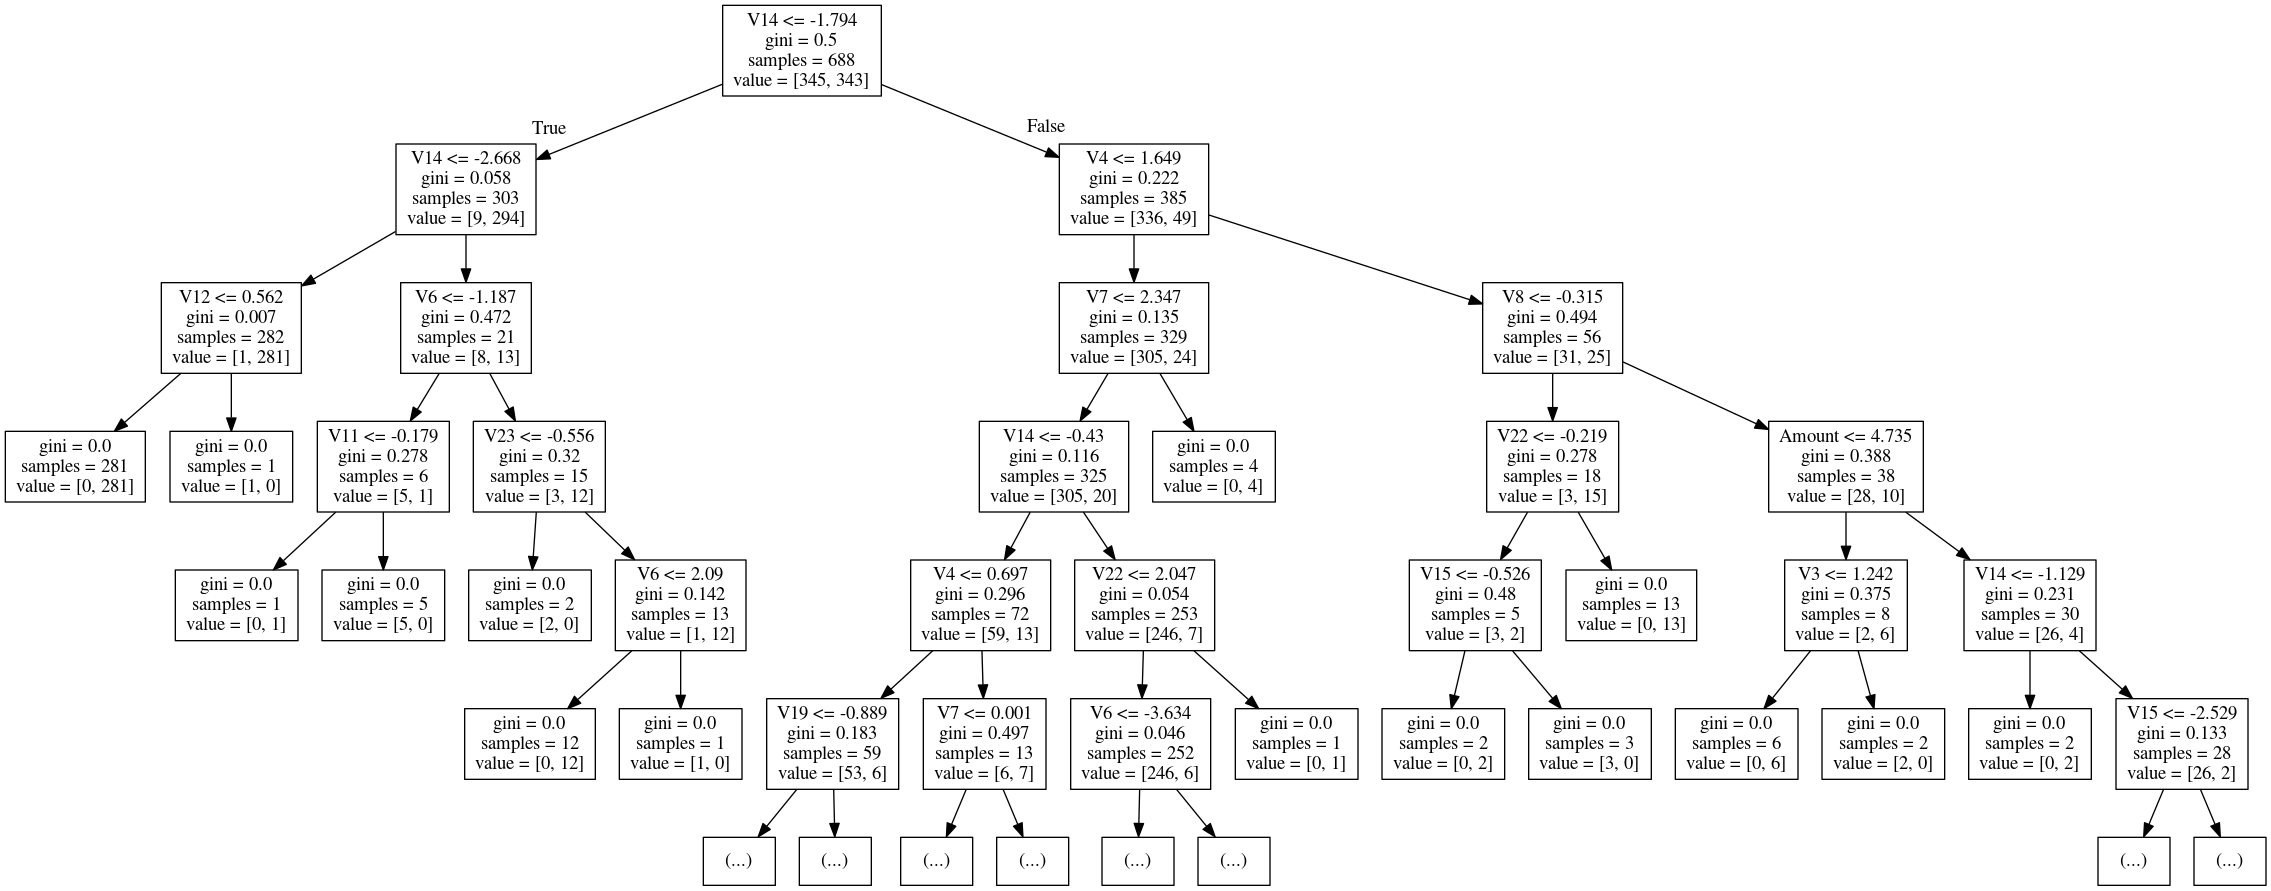

In [150]:
# 決定木による傾向分析

train_x, valid_x, train_y, valid_y = cross_validation.train_test_split(data_x_sample, data_y_sample, test_size=0.3, random_state=0)

decision_tree = tree.DecisionTreeClassifier()
decision_tree.fit(train_x, train_y)

dot_data = StringIO()
tree.export_graphviz(decision_tree, out_file=dot_data, feature_names=x_cols, max_depth=5)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_pdf('graph.pdf')
Image(graph.create_png())

In [144]:
df_tmp = df.copy()

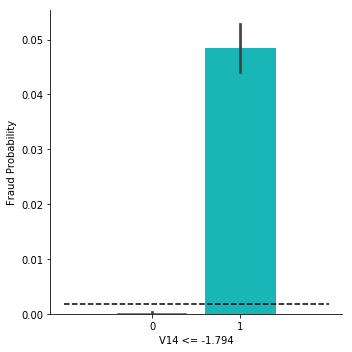

In [145]:
df_tmp.loc[df_tmp['V14'] <= -1.794, 'V14 <= -1.794'] = 1
df_tmp.loc[~(df_tmp['V14'] <= -1.794), 'V14 <= -1.794'] = 0
df_tmp['V14 <= -1.794'] = df_tmp['V14 <= -1.794'].astype(np.int)

g = sns.factorplot(x='V14 <= -1.794', y='Class',data=df_tmp, kind='bar', palette=[base_color2, base_color])
g = g.set_ylabels('Fraud Probability')
plt.hlines([df_tmp['Class'].sum()/len(df_tmp)], -1, 2, color='black', linestyles='--')
plt.show()

In [146]:
df_tmp[df_tmp['V14 <= -1.794'] == 1]['Class'].sum()/len(df_tmp[df_tmp['V14 <= -1.794'] == 1])

0.04848553345388788

In [147]:
df_tmp[df_tmp['V14 <= -1.794'] == 0]['Class'].sum()/len(df_tmp[df_tmp['V14 <= -1.794'] == 0])

0.00022829478292065125

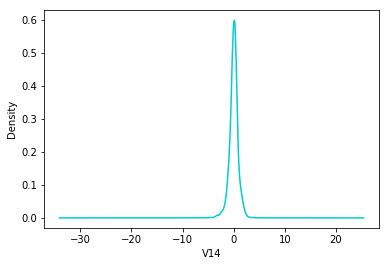

In [148]:
df_tmp['V14'].plot(kind='kde', color=base_color)
plt.xlabel('V14')
plt.show()

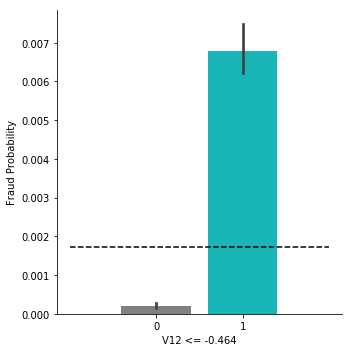

In [151]:
df_tmp = df.copy()
df_tmp.loc[df_tmp['V12'] <= -0.464, 'V12 <= -0.464'] = 1
df_tmp.loc[~(df_tmp['V12'] <= -0.464), 'V12 <= -0.464'] = 0
df_tmp['V12 <= -0.464'] = df_tmp['V12 <= -0.464'].astype(np.int)

g = sns.factorplot(x='V12 <= -0.464', y='Class',data=df_tmp, kind='bar', palette=[base_color2, base_color])
g = g.set_ylabels('Fraud Probability')
plt.hlines([df_tmp['Class'].sum()/len(df_tmp)], -1, 2, color='black', linestyles='--')
plt.show()

In [152]:
df_tmp[df_tmp['V12 <= -0.464'] == 1]['Class'].sum()/len(df_tmp[df_tmp['V12 <= -0.464'] == 1])

0.006788742256115195

In [153]:
df_tmp[df_tmp['V12 <= -0.464'] == 0]['Class'].sum()/len(df_tmp[df_tmp['V12 <= -0.464'] == 0])

0.00020994021267856328

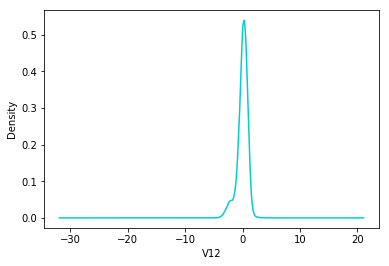

In [154]:
df_tmp['V12'].plot(kind='kde', color=base_color)
plt.xlabel('V12')
plt.show()

In [155]:
!python --version

Python 3.6.6 :: Anaconda custom (64-bit)


In [156]:
!pip freeze

absl-py==0.4.0
alabaster==0.7.11
algopy==0.5.7
altair==2.2.2
anaconda-client==1.7.1
anaconda-navigator==1.8.7
anaconda-project==0.8.2
annoy==1.12.0
appdirs==1.4.3
arrow==0.12.1
asn1crypto==0.24.0
astor==0.7.1
astroid==2.0.4
astropy==3.0.4
atomicwrites==1.1.5
attrs==18.1.0
audioread==2.1.6
Automat==0.7.0
Babel==2.6.0
backcall==0.1.0
backports.shutil-get-terminal-size==1.0.0
Baker==1.3
basemap==1.1.0
bayesian-optimization==0.6.0
bayespy==0.5.17
bcolz==1.2.1
beautifulsoup4==4.6.3
biopython==1.72
bitarray==0.8.3
bkcharts==0.2
blaze==0.11.3
bleach==2.1.4
blist==1.3.6
bokeh==0.13.0
Boruta==0.1.5
boto==2.49.0
boto3==1.7.84
botocore==1.10.84
Bottleneck==1.2.1
-e git+https://github.com/SohierDane/BigQuery_Helper@8615a7f6c1663e7f2d48aa2b32c2dbcb600a440f#egg=bq_helper
branca==0.3.0
cachetools==2.1.0
cairocffi==0.9.0
CairoSVG==2.1.3
Cartopy==0.16.0
catboost==0.9.1.1
category-encoders==1.2.8
certifi==2018.8.13
cffi==1.11.5
chainer==4.4.0
chardet==3.0.4
-e git+http://github.com/tensorflow/cleverhans